In [1]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta
from functools import reduce
import holidays
from sklearn.model_selection import train_test_split
from scipy.stats import kurtosis, skew
from load_data import load_data, split_data
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Data Prep


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta
from functools import reduce
import numpy as np
import pandas as pd
import holidays
from scipy.stats import kurtosis, skew


#load data
df_ntc = pd.read_csv("../data/NTC.csv", parse_dates=['datetime'])
df_ntc.set_index('datetime', inplace=True)
df_ntc.index = df_ntc.index.tz_localize('Europe/Brussels', ambiguous='infer')
df_ntc.index = df_ntc.index.tz_convert('UTC')

df_act_loss = pd.read_csv("../data/Avtice-losses.csv", skiprows=1, parse_dates=['Zeitstempel'], index_col='Zeitstempel')
df_act_loss = df_act_loss.rename(columns={"kWh": "mwh", "Zeitstempel": "datetime"})
df_act_loss.index.name = 'datetime'
df_act_loss.index = df_act_loss.index.tz_localize('Europe/Brussels', ambiguous='infer')
df_act_loss.index = df_act_loss.index.tz_convert('UTC')

df_weather_forecast = pd.read_csv("../data/Forecast-renewable-generation.csv", parse_dates=['datetime'])
df_weather_forecast.set_index('datetime', inplace=True)
df_weather_forecast.index = df_weather_forecast.index.tz_localize('Europe/Brussels', ambiguous='infer')
df_weather_forecast.index = df_weather_forecast.index.tz_convert('UTC')

df_weather_temp = pd.read_csv("../data/Forecast-temperature_new.csv", parse_dates=['datetime'])
df_weather_temp.set_index('datetime', inplace=True)
ambiguous_flags = [False] * len(df_weather_temp)  # Set all to False initially
ambiguous_idx = df_weather_temp.index.get_loc(pd.Timestamp("2019-10-27 02:00:00"))
ambiguous_flags[ambiguous_idx] = True  # Adjust as needed; True means it is DST
df_weather_temp.index = df_weather_temp.index.tz_localize('Europe/Brussels', ambiguous=ambiguous_flags)
df_weather_temp.index = df_weather_temp.index.tz_convert('UTC')
df_weather_temp = df_weather_temp.loc[~df_weather_temp.index.duplicated(keep='first')]
df_weather_temp = df_weather_temp.resample('1H').asfreq()
df_weather_temp = df_weather_temp.interpolate(method='cubic')

# You need to convert kWh to MWh by dividing it by 1000. As all other variables use MW.
df_act_loss['mwh'] = df_act_loss['mwh'].astype(float)
df_act_loss['mwh'] = df_act_loss['mwh'] / 1000.0

#downsample from 15 min to 1 hour
df_act_loss = df_act_loss.loc[~df_act_loss.index.duplicated(keep='first')]
df_act_loss = df_act_loss.resample('1H').sum()
df_act_loss = df_act_loss.interpolate()


#display
# display(df_ntc)
# display(df_act_loss)
# display(df_weather_forecast)
# display(df_weather_temp)


###Merge###
# List of DataFrames
dfs = [df_weather_forecast, df_act_loss, df_weather_temp]

# Merge all DataFrames on 'datetime'
merged_df = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='inner'), dfs)

# Function to determine the season
def determine_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Function to determine if the date is a public holiday in Switzerland
def is_public_holiday(date):
    swiss_holidays = holidays.Switzerland(years=date.year)
    return 1 if date in swiss_holidays else 0

# Function to determine if the date is a special day in Switzerland (you can define your own special days)
def is_special_day(date):
    special_days = [pd.Timestamp(f'{date.year}-08-01'), pd.Timestamp(f'{date.year}-12-25'), pd.Timestamp(f'{date.year}-01-01')]
    return 1 if date in special_days else 0

# Add feature columns
def add_feature_columns(df):
    # Add month feature
    df['Month'] = df.index.month
    df = pd.get_dummies(df, columns=['Month'], prefix='Month')

    df['Day_of_Week'] = df.index.dayofweek
    df = pd.get_dummies(df, columns=['Day_of_Week'], prefix='Day')

    df['Hour'] = df.index.hour
    df = pd.get_dummies(df, columns=['Hour'], prefix='Hour')

    return df

# Assuming merged_df is your DataFrame with datetime index
merged_df = add_feature_columns(merged_df)

#clean
merged_df.columns = merged_df.columns.str.replace('[":\[\]{}]', '', regex=True)
merged_df.columns = [col.replace(" ", "_") for col in merged_df.columns]
# display(merged_df)

df = merged_df.copy()
timeframe = 1 * 24

df['target'] = df['mwh']

df['std_mwh'] = df['mwh'].rolling(window=24).std()
# df['kurtosis'] = df['mwh'].rolling(window=24).apply(kurtosis)
# df['skewness'] = df['mwh'].rolling(window=24).apply(skew)

feature_columns = ['mwh', "std_mwh"] #drop it later

# df['kurtosis'] = df['mwh'].rolling(window=24).apply(kurtosis).shift(24)
# df['skewness'] = df['mwh'].rolling(window=24).apply(skew).shift(24)

# for col in feature_columns:
#     for i in range(1, timeframe + 1):  # Loop over 1 day's worth of hours, adjust as needed
#         lag_col_name = f'lag_{col}_{i}'  # Construct the lag column name
#         df[lag_col_name] = df[col].shift(i)  # Initially create lag columns
        
#         for idx, row in df.iterrows():
#             lag_time = idx - pd.Timedelta(hours=i)
#             # If the date portion of the lag time is the same as the current index, set it to NaN
#             if lag_time.date() == idx.date():
#                 df.at[idx, lag_col_name] = np.nan
        
for col in feature_columns:
    for i in range(1, timeframe + 1):
        lag_col_name = f'lag_{col}_{i}'
        
        # Create lag column
        df[lag_col_name] = df[col].shift(i)
        
        # Create an index of dates for each lag_time
        lag_time_index = df.index - pd.Timedelta(hours=i)
        
        # Set NaN where the date part is the same
        mask = (lag_time_index.date == df.index.date)
        df.loc[mask, lag_col_name] = np.nan

# df['std_mwh_24hr'] = df['mwh'].rolling(window=24).std().shift(24)
# df['kurtosis_mwh_24hr'] = df['mwh'].rolling(window=24).apply(kurtosis).shift(24)
# df['skewness_mwh_24hr'] = df['mwh'].rolling(window=24).apply(skew).shift(24)

df = df.iloc[timeframe:]

# df = df.copy()
df.fillna(-1, inplace=True)

df = df.drop(feature_columns, axis=1)
df.to_csv('df.csv')

In [42]:
df_weather_temp

,temperature_fore_ch,temperature_fore_fr,temperature_fore_de,temperature_fore_it
datetime,,,,
2019-01-01 00:00:00+00:00,4.106700,5.972900,7.426800,4.028100
2019-01-01 01:00:00+00:00,2.637812,5.080813,6.724312,2.372176
2019-01-01 02:00:00+00:00,1.701501,4.600184,6.284190,1.437560
2019-01-01 03:00:00+00:00,1.221641,4.468391,6.066192,1.115047
2019-01-01 04:00:00+00:00,1.122105,4.622812,6.030072,1.295434
...,...,...,...,...
2021-12-31 18:00:00+00:00,8.530000,9.960000,10.790000,9.590000
2021-12-31 19:00:00+00:00,8.000000,9.400000,10.630000,9.110000
2021-12-31 20:00:00+00:00,7.500000,8.880000,10.510000,8.670000


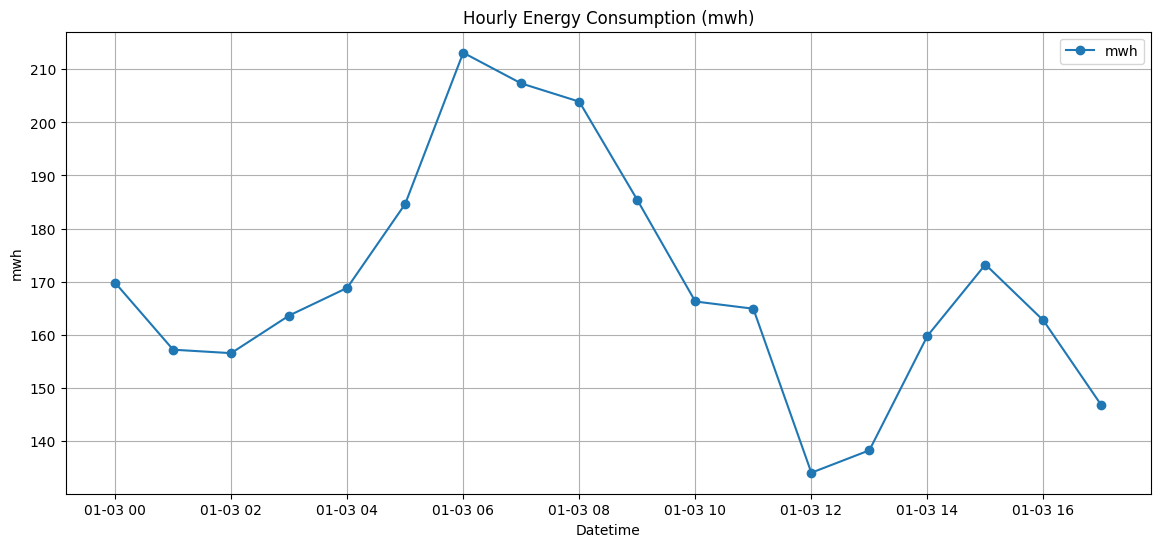

In [37]:
# Create a plot for the given data
plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(df.index[24:42]), df_act_loss["mwh"][24:42], marker='o', label='mwh')
plt.title('Hourly Energy Consumption (mwh)')
plt.xlabel('Datetime')
plt.ylabel('mwh')
plt.grid(True)
plt.legend()
plt.show()


In [22]:
df.columns

Index(['solar_fore_de_MW', 'solar_fore_it_MW', 'wind_fore_de_MW',
       'wind_fore_it_MW', 'temperature_fore_ch', 'temperature_fore_fr',
       'temperature_fore_de', 'temperature_fore_it', 'Month_1', 'Month_2',
       ...
       'lag_std_mwh_15', 'lag_std_mwh_16', 'lag_std_mwh_17', 'lag_std_mwh_18',
       'lag_std_mwh_19', 'lag_std_mwh_20', 'lag_std_mwh_21', 'lag_std_mwh_22',
       'lag_std_mwh_23', 'lag_std_mwh_24'],
      dtype='object', length=131)

# STOP

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col_name] = df[col].shift(i)
/tmp/ipykernel_108719/1335041470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use

In [25]:
# from numba import cuda

# # Initialize GPU
# cuda.select_device(0)

# # Reset GPU
# cuda.close()

In [15]:

# # Sort the DataFrame by datetime
# df.sort_index(inplace=True)

# # Train-test split based on timestamp
# train_size = int(len(df) * 0.8)
# train, test = df.iloc[:train_size], df.iloc[train_size:]

# # Features and target
# X_train, y_train = train.drop('target', axis=1), train['target']
# X_test, y_test = test.drop('target', axis=1), test['target']


In [16]:
# params = {
#     'objective': 'regression',
#     'metric': 'mae',
#     'boosting_type': 'gbdt',
#     'device': 'gpu',
#     'random_state': 42,
#     'gpu_platform_id' : 0,
#     'gpu_device_id': 0
# }

# # Create LightGBM data containers
# train_data = lgb.Dataset(X_train, label=y_train)
# test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)



# # Train the model
# num_round = 50
# bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# # Make predictions
# y_pred = bst.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, y_pred)

# print(f"RMSE: {rmse}")
# print(f"MAE: {mae}")

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 44585
[LightGBM] [Info] Number of data points in the train set: 20908, number of used features: 228
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA A100 80GB PCIe, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 176 dense feature groups (3.51 MB) transferred to GPU in 0.039039 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 106.986450


KeyboardInterrupt: 

In [ ]:
# import shap

# # Initialize JavaScript for SHAP plots
# shap.initjs()

# # Create SHAP explainer
# explainer = shap.Explainer(bst)

# # Calculate SHAP values for test data
# shap_values = explainer(X_test)

# # Plot SHAP summary
# shap.summary_plot(shap_values, X_test)


In [ ]:
# # LightGBM parameters
# # Define the grid of hyperparameters to search
# param_grid = {
#     'objective': ['regression'],
#     'metric': ['mae'],
#     'boosting_type': ['gbdt'],
#     'num_leaves': [31, 127],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [20, 40],
#     'device': ['gpu'],
#     'gpu_platform_id': [0],
#     'gpu_device_id': [0]
# }

# # Create a LightGBM model
# lgb_estimator = lgb.LGBMRegressor()

# # Create the GridSearchCV object
# gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, 
#                        scoring='neg_mean_absolute_error', cv=3)
# # Fit the grid search to the data
# gsearch.fit(X_train, y_train)

# # Print the best parameters
# print("Best parameters found: ", gsearch.best_params_)

# # Get the best model
# best_model = gsearch.best_estimator_

# # Make predictions with the best model
# y_pred = best_model.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, y_pred)

# print(f"RMSE: {rmse}")
# print(f"MAE: {mae}")
